In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import numpy as np
from astropy.table import QTable
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from sklearn import mixture
from sklearn.mixture import BayesianGaussianMixture

import warnings
warnings.filterwarnings('ignore')
plt.style.use(astropy_mpl_style)

In [2]:
from astroquery.gaia import Gaia
from astropy.table import QTable

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [26]:
#pulling new data from Gaia DR2
job = Gaia.launch_job_async("""SELECT source_id,ra,dec,parallax,parallax_error,pmra,pmdec,radial_velocity,radial_velocity_error,l,b
        FROM gaiadr2.gaia_source 
        WHERE 1/parallax <=300 AND phot_g_mean_mag < 11 AND parallax_error < 0.05 AND radial_velocity_error < 0.5 AND astrometric_excess_noise < 0.2""" \
                           , dump_to_file=True)
print(job)

Jobid: 1532631731168O
Phase: COMPLETED
Owner: None
Output file: async_20180726120211.vot
Results: None


In [2]:
#reading in data file pulled from Gaia archive

gaiatable = QTable.read('async_20180726120211.vot', format='votable')
print(gaiatable)

     source_id              ra         ...          b         
                           deg         ...         deg        
------------------- ------------------ ... -------------------
4464022263949414656 245.35607894779315 ...   39.74601765022799
4150349596757113216  269.3461532773476 ...   5.368017191761381
5800578909257104768  224.7983909260933 ... -7.2787173150569275
4464140495809025536 245.58676937561606 ...   39.67798499288988
6680753669662453632  307.0744320583884 ...  -34.97016134516246
5781872917909807104 234.60164840233816 ... -15.773105303745695
1872329115113060096 316.02469301929153 ...  -4.860480492570544
5781834263203687168 237.12140991077598 ... -16.224147313226055
4464016628952145152 244.99013836130197 ...   40.11627787617376
5781816396139574784  237.6496980829844 ... -16.463176021830314
                ...                ... ...                 ...
4464231583476264064  243.7664320404398 ...   40.79833504170132
5408425167926392576 151.24886074800943 ...   6.96188144

In [3]:
#establishing variables from column names
ra_gaia = gaiatable['ra']
dec_gaia = gaiatable['dec']
plx = gaiatable['parallax']
#gmag = gaiatable['phot_g_mean_mag']
pmra = gaiatable['pmra']
pmdec = gaiatable['pmdec']
#bpmag = gaiatable['phot_bp_mean_mag']
#rpmag = gaiatable['phot_rp_mean_mag']
radvel = gaiatable['radial_velocity']
#teff = gaiatable['teff_val']
galong = gaiatable['l']
galat = gaiatable['b']

In [4]:
#inputting variables into a coordinates object for future manipulation

c1 = coord.ICRS(ra=ra_gaia, dec=dec_gaia,
                distance=(plx).to(u.pc, u.parallax()),
                pm_ra_cosdec=(pmra.value*np.cos(pmdec.value))*u.mas/u.yr,
                pm_dec=(pmdec.value)*u.mas/u.yr,
                radial_velocity=(radvel.value)*u.km/u.s
               )

In [5]:
#transforming coordinates from reference frame given in Gaia DR2 to galactocentric frame

gc1 = c1.transform_to(coord.Galactocentric)
galv_x = gc1.v_x
galv_y = gc1.v_y
galv_z = gc1.v_z
print(gc1.v_x, gc1.v_y, gc1.v_z)

[ 10.58795278  31.83474182  29.39710872 ... -12.45303826  23.58369138
  -3.97286652] km / s [194.81769244 204.61551157 212.10557568 ... 225.43128023 205.06565331
 229.90106069] km / s [  9.76622864 -17.68977753  -2.02217972 ...   9.51137532  -1.83935494
  11.91082429] km / s


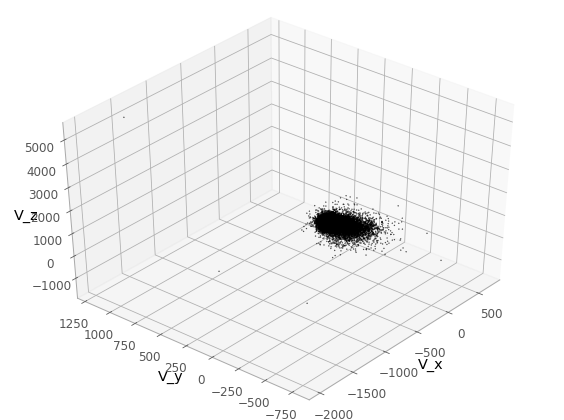

In [31]:
#making a 3D plot of galactocentric velocities

vx = galv_x
vy = galv_y
vz = galv_z

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("V_x")
ax.set_ylabel("V_y")
ax.set_zlabel("V_z")

ax.scatter(vx, vy, vz, c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

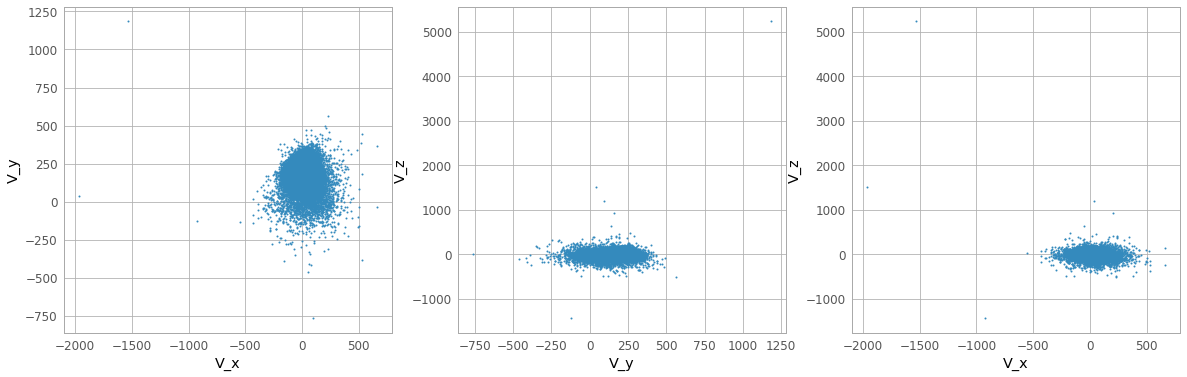

In [32]:
#the same plot as above but in 2D

fig, ax = plt.subplots(1,3);
fig.set_size_inches(20,6)


ax[0].set_xlabel("V_x")
ax[0].set_ylabel("V_y")

ax[1].set_xlabel("V_y")
ax[1].set_ylabel("V_z")

ax[2].set_xlabel("V_x")
ax[2].set_ylabel("V_z")

ax[0].scatter(vx, vy, s=1);
ax[1].scatter(vy, vz, s=1);
ax[2].scatter(vx, vz, s=1);

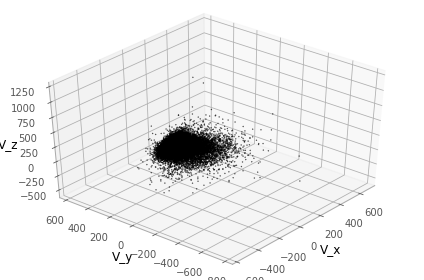

In [13]:
#making a 3D plot of galactocentric velocities but with a mask to cut out some outliers

mask1 = np.where((galv_x.value > -600) & (galv_y.value < 750)
                & (galv_z.value < 2000))

vx = galv_x[mask1]
vy = galv_y[mask1]
vz = galv_z[mask1]

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("V_x")
ax.set_ylabel("V_y")
ax.set_zlabel("V_z")

ax.scatter(vx, vy, vz, c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

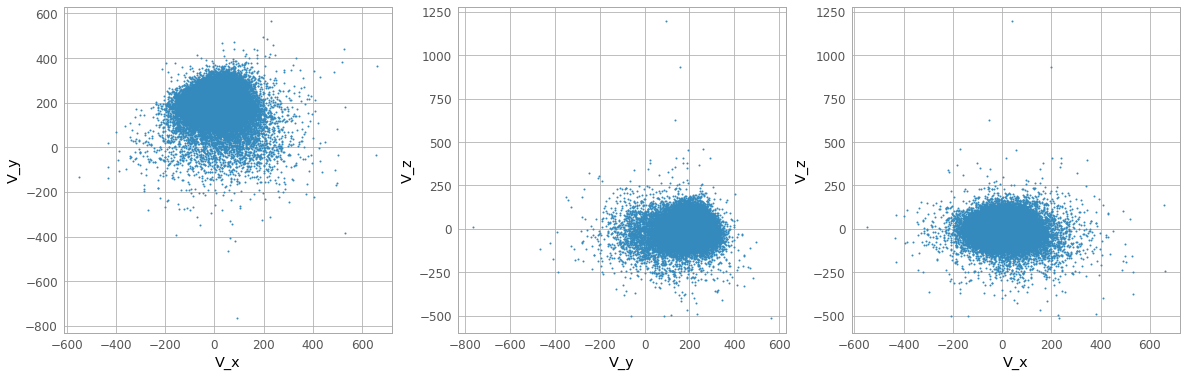

In [34]:
fig, ax = plt.subplots(1,3);
fig.set_size_inches(20,6)


ax[0].set_xlabel("V_x")
ax[0].set_ylabel("V_y")

ax[1].set_xlabel("V_y")
ax[1].set_ylabel("V_z")

ax[2].set_xlabel("V_x")
ax[2].set_ylabel("V_z")

ax[0].scatter(vx, vy, s=1);
ax[1].scatter(vy, vz, s=1);
ax[2].scatter(vx, vz, s=1);

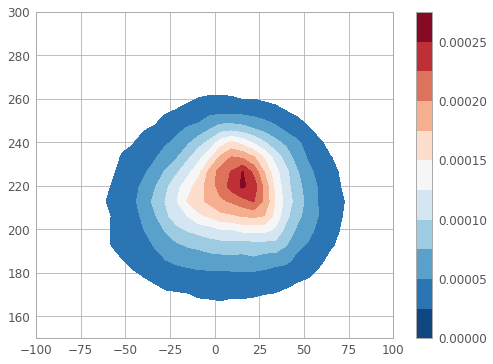

In [37]:
#kernel density estimate plot for the x and y components of galactocentric velocities

sns.kdeplot(vx.value, vy.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([150,300])
plt.xlim([-100,100])
plt.show()

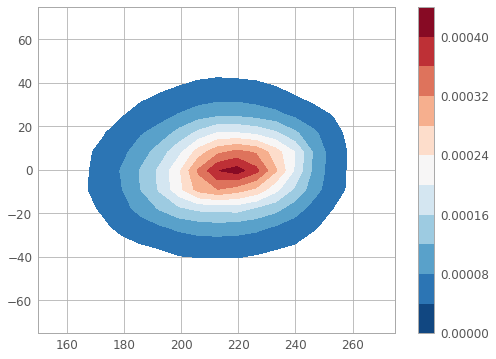

In [39]:
#kernel density estimate plot for the y and z components of galactocentric velocities

sns.kdeplot(vy.value, vz.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.xlim([150,275])
plt.ylim([-75,75])
plt.show()

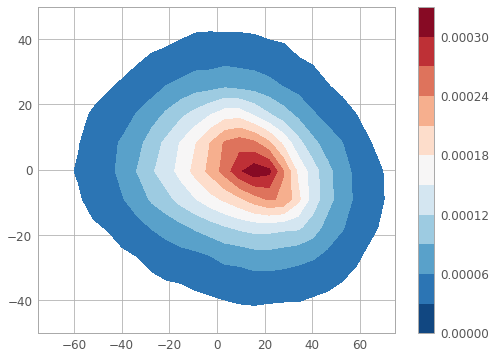

In [40]:
#kernel density estimate plot for the x and z components of galactocentric velocities

sns.kdeplot(vx.value, vz.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([-50,50])
plt.xlim([-75,75])
plt.show()

In [14]:
#prepping kmeans, making a mask to remove outliers and focus on main cluster of sources,
# plotting kmeans for x and y components of galactocentric velocities

mask = np.where((galv_x.value < 150) & (galv_x.value > -150) & (galv_y.value < 500)
                & (galv_y.value > 90) & (galv_z.value < 600) & (galv_z.value > -125))

xmasked = galv_x[mask]
ymasked = galv_y[mask]
zmasked = galv_z[mask]

fullarray = np.array([vx, vy, vz]).T
vsarray = np.array([xmasked, ymasked, zmasked]).T

#kmeans = KMeans(n_clusters=7)
#kmeans.fit(fullarray)
#y_kmeans = kmeans.predict(fullarray)

#plt.scatter(fullarray[:, 0], fullarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);

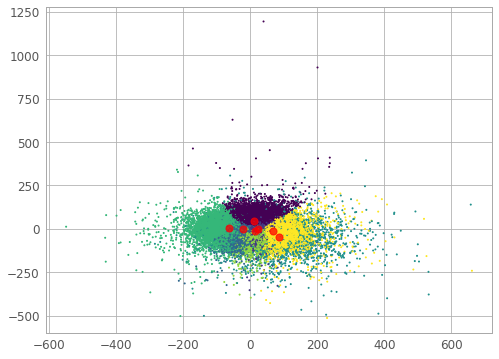

In [42]:
#plotting kmeans for x and z components of galactocentric velocities

plt.scatter(fullarray[:, 0], fullarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=50, alpha=0.75);

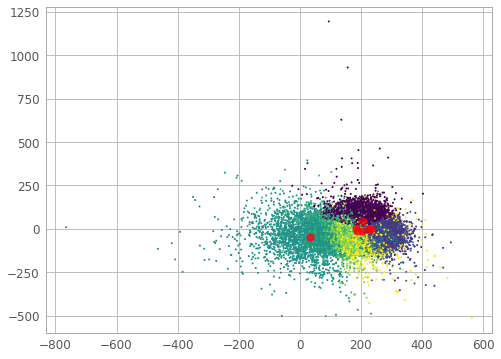

In [43]:
# plotting kmeans for y and z components of galactocentric velocities

plt.scatter(fullarray[:, 1], fullarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);

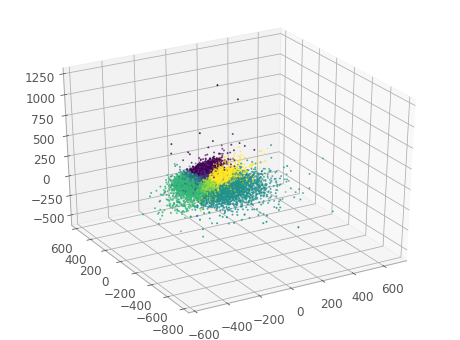

In [44]:
#A 3D plot of the three above 2D plots, unsure if centers are not visible because of coding error or just visual obstruction

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.scatter(fullarray[:, 0], fullarray[:, 1], fullarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);

ax.view_init(azim = -120, elev = 30);

In [6]:
#making a randomized subsample for quicker computations

vxdata = galv_x.value
vydata = galv_y.value
vzdata = galv_z.value

idx = np.random.choice(np.arange(len(vxdata)), 3000)
randarray = np.array([vxdata[idx], vydata[idx], vzdata[idx]]).T
print(randarray)

[[-5.82361667e+00  1.69223979e+02 -1.21230401e+01]
 [ 6.36874782e+01  2.43075070e+02 -2.89211328e+01]
 [-5.93364020e-02  2.29261260e+02  8.95330815e+00]
 ...
 [-4.74000295e+00  1.97843809e+02  2.47934991e+01]
 [ 2.64260863e+01  2.13400020e+02 -2.21329565e+01]
 [-8.93270545e+00  2.41080776e+02 -2.38491995e+01]]


In [8]:
#code temporarily borrowed from scikit-learn's mixture package's 
#gaussian mixture model ellipsoid example

import itertools
from scipy import linalg

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(111)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        #angle = np.arctan(u[1] / u[0])
        #angle = 180. * angle / np.pi  # convert to degrees
        #ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        #ell.set_alpha(0.5)
        #splot.add_artist(ell)

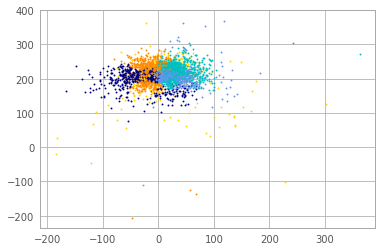

In [18]:
gmm = mixture.GaussianMixture(n_components=20, covariance_type='full').fit(randarray)
plot_results(randarray, gmm.predict(randarray), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')
plt.show()

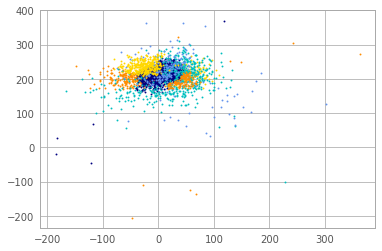

In [19]:
dpgmm = mixture.BayesianGaussianMixture(n_components=20,
                                        covariance_type='full').fit(randarray)
plot_results(randarray, dpgmm.predict(randarray), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')
plt.show()

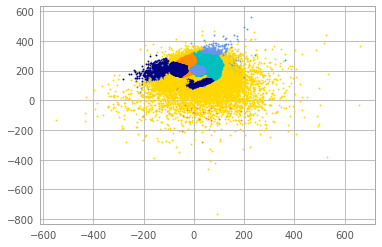

In [20]:
plot_results(fullarray, gmm.predict(fullarray), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')
plt.show()

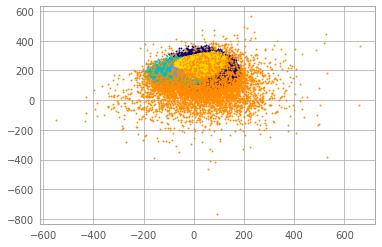

In [21]:
dpgmm = mixture.BayesianGaussianMixture(n_components=7,
                                        covariance_type='full').fit(fullarray)
plot_results(fullarray, dpgmm.predict(fullarray), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')
plt.show()